## Setting environment

In [1]:
# %matplotlib widget
# import ipywidgets as widgets
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
pd.options.display.float_format = "{:,.4f}".format

# Get the current working directory
path_this = os.getcwd()
path_data = os.path.join(path_this, './Data_Duval/')

# Duval limits
lim_duval = np.log10([
    100,  # H2
    1e9,  # CH4
    300,  # C2H2
    100,  # C2H4
    20,   # C2H6
    1e9,  # CO
    1e9   # CO2
])

# How many times shall we run the experiments
indJ = 1

# Ratio of negative vs. positive samples
frac_neg = [0.3, 0.4, 0.5, 0.6, 0.7]

# Percentage of data being cross-validated
thres_xval = 0.8

## helper functions

In [2]:
def Duval_ImportData(filename, n_cols, n_cols_text):
    # Initialize empty lists for text and numerical data
    text_data, numerical_data = [], []

    with open(filename, 'r') as file:
        i = 0
        for line in file:
            if i < n_cols_text:
                # Append text data
                text_data.append(line.strip())
            else:
                # Process and append numerical data
                try:
                    num = float(line.strip()) if line.strip() != '-' else 0
                    numerical_data.append(num)
                except ValueError:
                    # In case of non-numeric value, append None
                    numerical_data.append(None)
            # Update indices
            i = i + 1 if (i + 1) < (n_cols + n_cols_text) else 0
    # Reshape the numerical data into a matrix
    mat = [numerical_data[i:i + n_cols] for i in range(0, len(numerical_data), n_cols)]

    # Reshape the text data into pairs
    text = [text_data[i:i + n_cols_text] for i in range(0, len(text_data), n_cols_text)]

    text_df = pd.DataFrame(text, columns=['Category', 'Description'])
    num_df = pd.DataFrame(mat)
    # num_df.columns = ['H_2', 'CH_4', 'C_2H_2', 'C_2H_4', 'C_2H_6', 'CO', 'CO_2', 'Ref']
    # return mat, text
    return num_df, text_df

def DGOA_Inputs_LogNormalize(df, base):
    df = df.replace(0, 1) # Replace 0 with 1
    df = np.log10(df) # Apply logarithm of base 10
    df = (df - df.mean()) / df.std() # Z-normalize (standardize)
    return df

def Duval_GenerateData(ranges, n):
    n_rows = ranges.shape[0]
    mat = np.random.rand(n, n_rows)
    for k in range(n_rows):
        min_k = np.min(ranges[k, :])
        max_k = np.max(ranges[k, :])
        mat[:, k] = mat[:, k] * (max_k - min_k) + min_k
    return mat

def DGOA_PlotDGOA3D(x, y, labels, labels_y, labels_type, fig, subplot_num):
    y = pd.Series(y)
    (nrows, ncols, index) = subplot_num
    ax = fig.add_subplot(nrows, ncols, index, projection='3d')
    
    # x is a numpy array of shape (D, N)
    for i, label in enumerate(labels_y):
        idx = y == i
        ax.scatter(x[x.columns[0]][idx], x[x.columns[1]][idx], x[x.columns[2]][idx], label=label)
    ax.set_xlabel(f'${labels[0]}$')
    ax.set_ylabel(f'${labels[1]}$')
    ax.set_zlabel(f'${labels[2]}$')
    ax.set_title(f'{labels_type}: ${labels[0]}$, ${labels[1]}$, ${labels[2]}$')
    return ax


def Duval_PrepareData(path_data, file_index, frac_neg, do_display):
    # Faulty transformers
    duvalPD, duvalPD_text = Duval_ImportData(os.path.join(path_data, 'DuvalTable2.txt'), 8, 2)
    duvalD1, duvalD1_text = Duval_ImportData(os.path.join(path_data, 'DuvalTable3.txt'), 8, 2)
    duvalD2, duvalD2_text = Duval_ImportData(os.path.join(path_data, 'DuvalTable4.txt'), 8, 2)
    duvalT1T2, duvalT1T2_text = Duval_ImportData(os.path.join(path_data, 'DuvalTable5.txt'), 8, 2)
    duvalT3, duvalT3_text = Duval_ImportData(os.path.join(path_data, 'DuvalTable6.txt'), 8, 2)
    # Normal transformers
    duvalNormalNoOLTC, duvalNormalNoOLTC_text = Duval_ImportData(os.path.join(path_data, 'DuvalAnnex2Table1.txt'), 8, 2);
    duvalNormalOLTC, duvalNormalOLTC_text = Duval_ImportData(os.path.join(path_data, 'DuvalAnnex2Table2.txt'), 8, 2);
    duvalNormalInst, duvalNormalInst_text = Duval_ImportData(os.path.join(path_data, 'DuvalAnnex2Table4.txt'), 8, 2);

    # Define ranges for normal transformers
    duvalNormalNoOLTCrange = np.array([[60, 150], [40, 110], [3, 50], [60, 280], [50, 90], [540, 900], [5100, 13000], [10, 10]])
    duvalNormalOLTCrange = np.array([[75, 150], [35, 130], [80, 270], [110, 250], [50, 70], [400, 850], [5300, 12000], [10, 10]])
    duvalNormalInstRange = np.array([[6, 300], [11, 120], [1, 5], [3, 40], [7, 130], [250, 1100], [800, 4000], [10, 10]])

    # Concatenate positive and negative data
    # Positive = faulty, negative = normal
    duvalPos = pd.concat([duvalPD, duvalD1, duvalD2, duvalT1T2, duvalT3], axis=0)
    duvalNeg = pd.concat([duvalNormalNoOLTC, duvalNormalOLTC, duvalNormalInst], axis=0)
    duvalPos.to_csv('./CSV/duvalPos.csv', index=False)
    duvalNeg.to_csv('./CSV/duvalNeg.csv', index=False)

    # Calculate number of additional samples to generate
    # Since there are 117 faulty samples and 50 normal ones, we generate 
    # 66 additional normal samples in order to balance the datasets
    n_pos = duvalPos.shape[0]
    n_neg = duvalNeg.shape[0] 
    n_neg_rand = (n_pos * frac_neg + n_neg * (frac_neg - 1)) / (1 - frac_neg)
    n = round(n_neg_rand / 3)

    # Generate additional data
    duvalNormalNoOLTCrand = Duval_GenerateData(duvalNormalNoOLTCrange, n)
    duvalNormalOLTCrand = Duval_GenerateData(duvalNormalOLTCrange, n)
    duvalNormalInstRand = Duval_GenerateData(duvalNormalInstRange, n)

    duvalNormalNoOLTCrand_df = pd.DataFrame(duvalNormalNoOLTCrand)
    duvalNormalOLTCrand_df = pd.DataFrame(duvalNormalOLTCrand)
    duvalNormalInstRand_df = pd.DataFrame(duvalNormalInstRand)

    # Concatenate the DataFrames along rows (axis=0)
    duvalNeg = pd.concat([duvalNeg, duvalNormalNoOLTCrand_df, duvalNormalOLTCrand_df, duvalNormalInstRand_df])

    # Remove last row and set column names
    gasNames = ['H_2', 'CH_4', 'C_2H_2', 'C_2H_4', 'C_2H_6', 'CO', 'CO_2']
    duvalPos = duvalPos.iloc[:, 0:7]
    duvalNeg = duvalNeg.iloc[:, 0:7]

    # # Save the raw dataset
    filename_raw = f'{path_data}/Duval_Raw_{file_index}.mat'
    scipy.io.savemat(filename_raw, {'duvalPos': duvalPos, 'duvalNeg': duvalNeg})
    duvalNeg.to_csv(f'./CSV/duvalNeg_Mirowski_{frac_neg}.csv', index=False)

    # Prepare data for the classifier
    dgoa = pd.concat([duvalPos, duvalNeg], axis=0)
    n_neg = duvalNeg.shape[0]
    labels = [1] * n_pos + [0] * n_neg
    # Normalization step
    dgoa = DGOA_Inputs_LogNormalize(dgoa,10)
    dgoa = dgoa.reset_index(drop=True)

    # # Save the processed data
    filename_proc = f'{path_data}/Duval_Classification_{file_index}.mat'
    scipy.io.savemat(filename_proc, {'dgoa': dgoa, 'labels': labels, 'gasNames': gasNames})

    if do_display == 1:
        classNames = ['Normal', 'Fault']
        # Visualize the data in 3D
        fig = plt.figure(figsize=(4*5,1*5), dpi=100)
        DGOA_PlotDGOA3D(dgoa[[0, 5, 6]], labels, [gasNames[i] for i in [0, 5, 6]], classNames, 'Duval', fig, (1,4,1))
        DGOA_PlotDGOA3D(dgoa[[2, 3, 4]], labels, [gasNames[i] for i in [2, 3, 4]], classNames, 'Duval', fig, (1,4,2))
        DGOA_PlotDGOA3D(dgoa[[0, 1, 3]], labels, [gasNames[i] for i in [0, 1, 3]], classNames, 'Duval', fig, (1,4,3))
        plt.legend()

        demo_x, demo_y = 1, 3
        ax = fig.add_subplot(1,4,4) 
        ax.scatter(dgoa[demo_x][n_pos:], dgoa[demo_y][n_pos:], marker='o', label='normal')
        ax.scatter(dgoa[demo_x][:n_pos], dgoa[demo_y][:n_pos], marker='x', label='faulty')
        ax.set_xlabel(f'${gasNames[demo_x]}$')
        ax.set_ylabel(f'${gasNames[demo_y]}$')
        fig.suptitle(f'Fraction of negative samples: {frac_neg}')
        plt.legend()
        plt.show()
    return filename_raw, filename_proc, dgoa, labels, gasNames


## start model fitting

In [3]:
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

def evaluate_metrics(y_test, y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return accuracy, roc_auc, tpr, fpr

def Duval_EvaluateML(dgoa, labels, thres_xval, models):
    res = defaultdict(list)
    scaler = StandardScaler()
    dgoaNorm = scaler.fit_transform(dgoa)
    labels = np.array(labels)
    n_val = 10
    n_splits = int(1 / (1-thres_xval)) # Determine number of splits based on threshold

    for model_name, model in models:
        accuracy_scores, aucs, tprs, fprs = [], [], [], []
        for validation_run in range(n_val):
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
            for train_index, test_index in skf.split(dgoaNorm, labels):
                X_train, X_test = dgoaNorm[train_index], dgoaNorm[test_index]
                y_train, y_test = labels[train_index], labels[test_index]
                model.fit(X_train, y_train) # Fit the model
                
                # Predict probabilities and labels
                y_prob = model.predict_proba(X_test)[:, 1] 
                y_pred = model.predict(X_test)
                
                accuracy, roc_auc, tpr, fpr = evaluate_metrics(y_test, y_pred, y_prob) # Evaluate metrics

                accuracy_scores.append(accuracy)
                aucs.append(roc_auc)
                tprs.append(tpr)
                fprs.append(fpr)
        
        # Calculate mean metrics for each model
        res[f"{model_name}_accuracy"] = np.mean(accuracy_scores)
        res[f"{model_name}_auc"] = np.mean(aucs)
        res[f"{model_name}_tpr"] = np.mean(tprs)
        res[f"{model_name}_fpr"] = np.mean(fprs)

    return res


## creating the main code part with loop

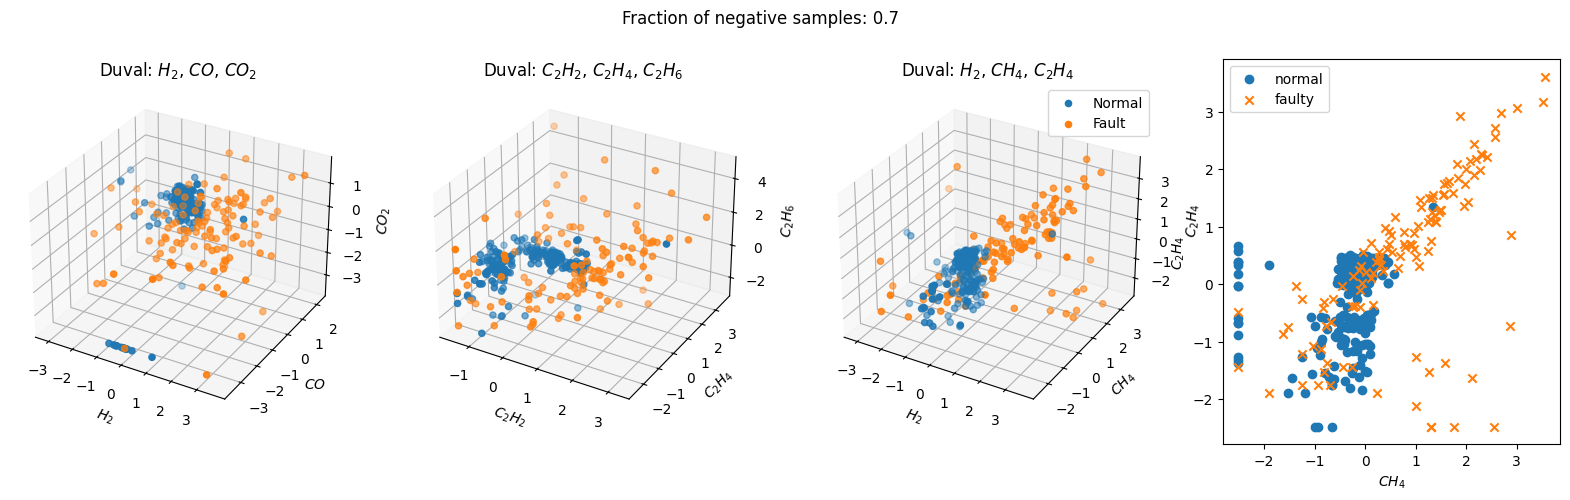

/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

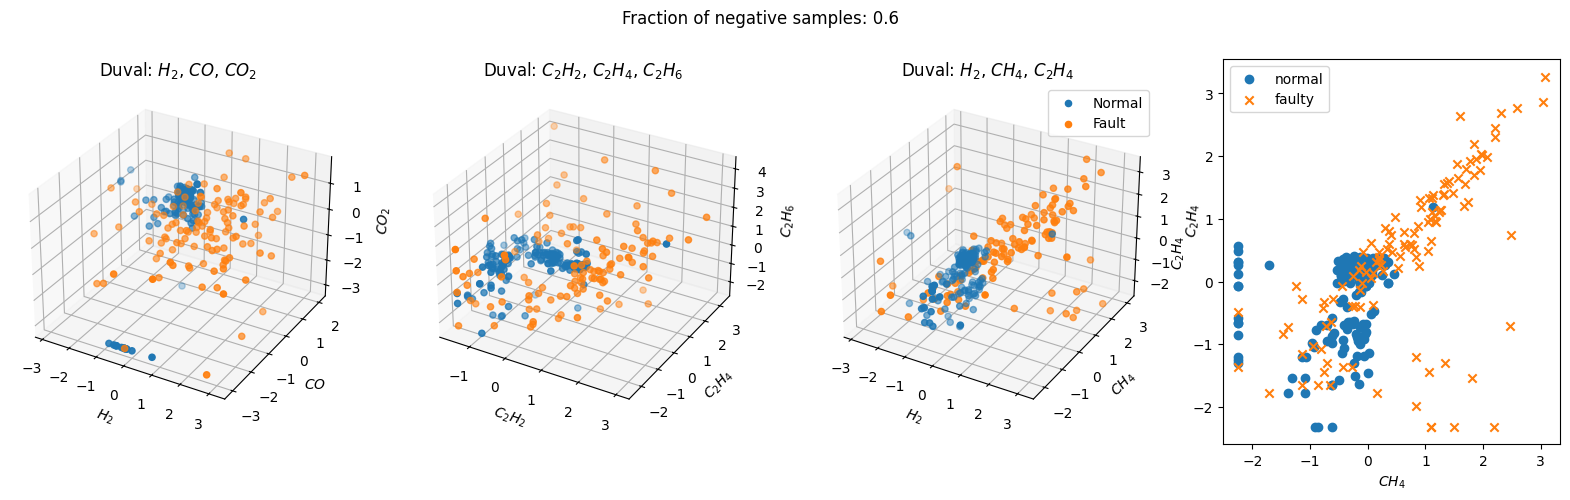

/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

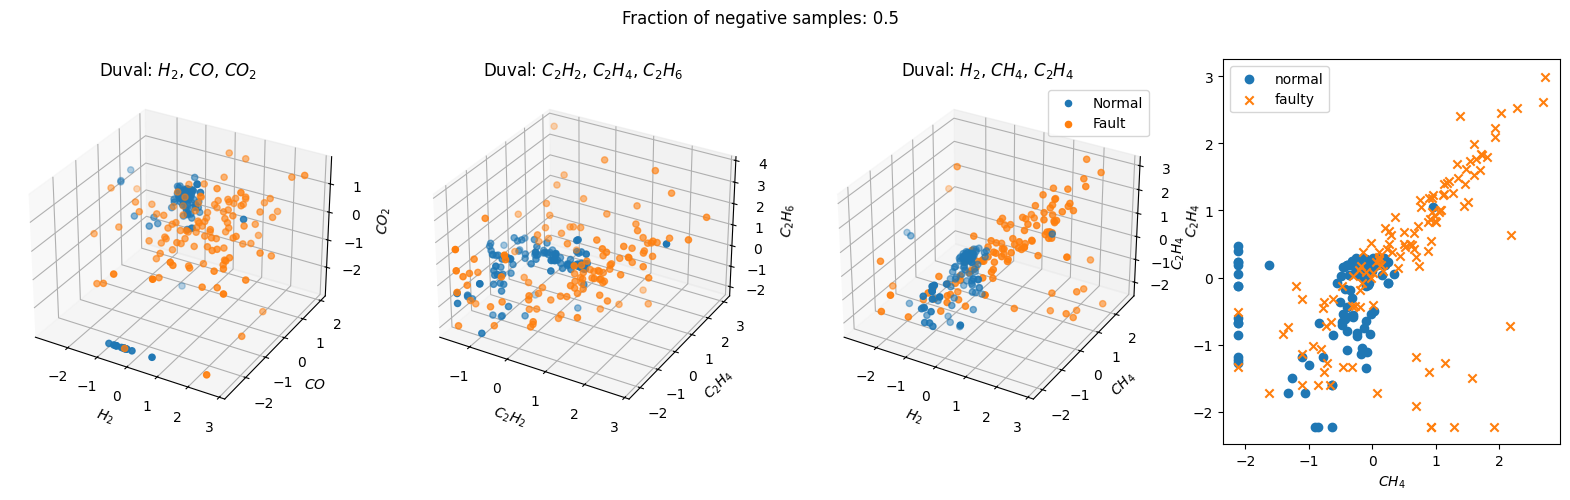

/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

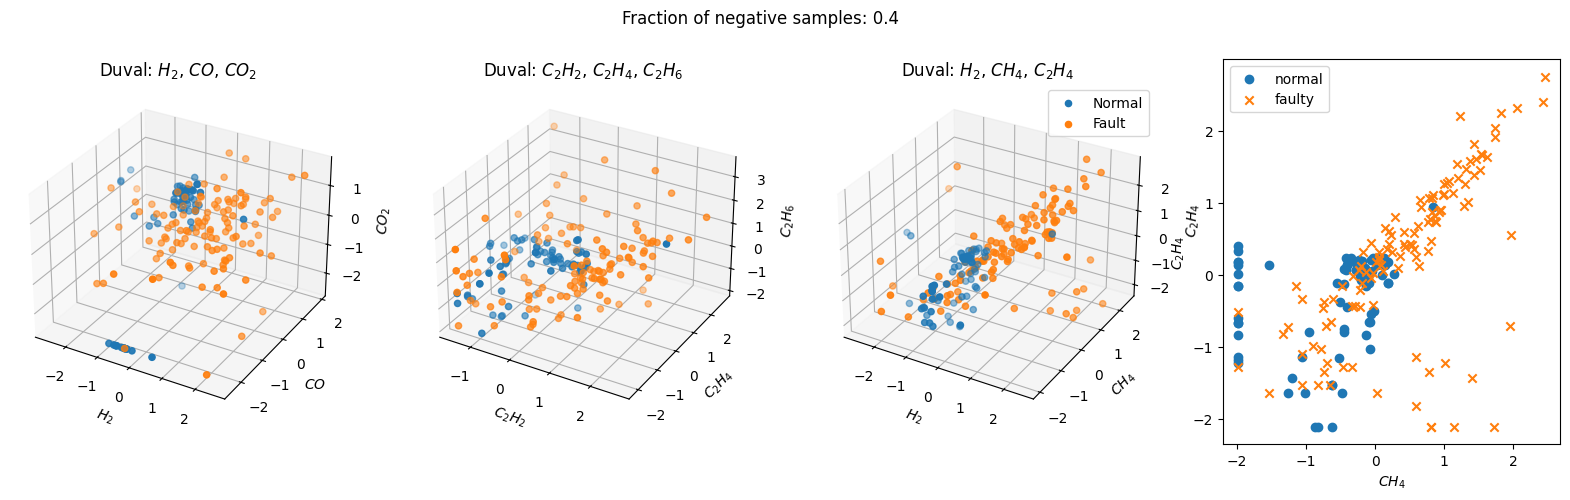

/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

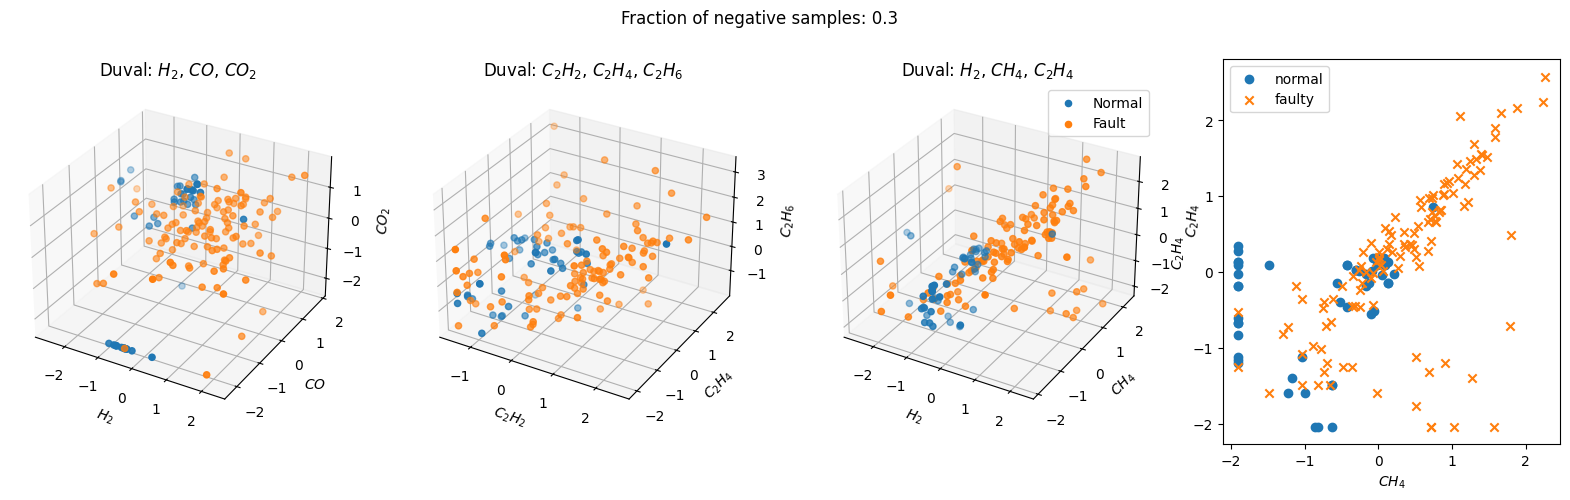

/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/test2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

In [4]:
# Initialize dictionaries to store statistics for each model
stats_mean = {}
stats_std = {}
models = [
    ("kNN", KNeighborsClassifier(n_neighbors=5)),
    ("LinearSVM", SVC(kernel='linear', probability=True)), # Ensure probability=True for SVC
    ("QuadSVM", SVC(kernel='poly', degree=2, probability=True)),
    ("GaussianSVM", SVC(kernel='rbf', probability=True)),
    ("RandomForest", RandomForestClassifier()),
    ("neural_network", MLPClassifier(hidden_layer_sizes=(5,), activation='tanh', solver='adam', max_iter=1000)),
]

stats = {}
# Main loop over the experiments and ratios of samples
for j in range(indJ, indJ + 1):
    for i in range(len(frac_neg)-1, -1, -1):
        f = frac_neg[i]

        # Prepare the data
        filename_raw, filename_proc, dgoa, labels, gasNames = Duval_PrepareData(path_data, i * 10 + j, f, 1)

        # Run the classification using Duval thresholds
        labelsDuval = np.sum(dgoa > lim_duval, axis=1)
        accuracy_Duval = np.mean( (labelsDuval > 0) == labels ) * 100
        
        # Run the classification using several ML techniques
        res = Duval_EvaluateML(dgoa, labels, thres_xval, models)

        for key in res:
            stats_mean[f"{key}_mean", i, j] = np.mean(res[key])
            stats_std[f"{key}_std", i, j] = np.std(res[key])
        scipy.io.savemat(f'./Data_Duval/Duval_Statistics/Duval_Statistics_{j}_{f}.mat', {'stats_mean': stats_mean, 'stats_std': stats_std})

        for key in res:
            if key not in stats:
                stats[key] = []
            # Append results to the list
            stats[key].append(res[key])

stats_df = pd.DataFrame(stats)
stats_mean = stats_df.mean()*100
stats_std = stats_df.std()*100
stats_df.to_csv('./CSV/Duval_Statistics.csv')

In [5]:
display(stats_df)

,kNN_accuracy,kNN_auc,kNN_tpr,kNN_fpr,LinearSVM_accuracy,LinearSVM_auc,LinearSVM_tpr,LinearSVM_fpr,QuadSVM_accuracy,QuadSVM_auc,...,GaussianSVM_tpr,GaussianSVM_fpr,RandomForest_accuracy,RandomForest_auc,RandomForest_tpr,RandomForest_fpr,neural_network_accuracy,neural_network_auc,neural_network_tpr,neural_network_fpr
0,0.9501,0.9639,0.8468,0.0055,0.9231,0.8995,0.7734,0.0125,0.8558,0.9117,...,0.8931,0.0155,0.9609,0.9878,0.9034,0.0144,0.9255,0.9596,0.7867,0.0147
1,0.9348,0.9638,0.8461,0.0062,0.9092,0.9087,0.8000,0.0182,0.7907,0.8761,...,0.8811,0.0228,0.9491,0.9867,0.9092,0.0244,0.9215,0.9612,0.8375,0.0226
2,0.9227,0.9616,0.8609,0.0146,0.8821,0.9018,0.8071,0.0421,0.7400,0.8613,...,0.8784,0.0303,0.9364,0.9823,0.9166,0.0440,0.8927,0.9483,0.8299,0.0440
3,0.9083,0.9546,0.8661,0.0272,0.8814,0.9081,0.8427,0.0594,0.7102,0.8591,...,0.8884,0.0652,0.9242,0.9745,0.9237,0.0747,0.8934,0.9454,0.8609,0.0575
4,0.8983,0.9487,0.8857,0.0720,0.8712,0.9067,0.8761,0.1400,0.7697,0.8594,...,0.9301,0.1200,0.9222,0.9631,0.9392,0.1180,0.8917,0.9439,0.9035,0.1360


In [6]:
stats_df.mean()

kNN_accuracy              0.9229
kNN_auc                   0.9585
kNN_tpr                   0.8611
kNN_fpr                   0.0251
LinearSVM_accuracy        0.8934
LinearSVM_auc             0.9050
LinearSVM_tpr             0.8198
LinearSVM_fpr             0.0544
QuadSVM_accuracy          0.7733
QuadSVM_auc               0.8735
QuadSVM_tpr               0.7183
QuadSVM_fpr               0.2901
GaussianSVM_accuracy      0.9283
GaussianSVM_auc           0.9758
GaussianSVM_tpr           0.8942
GaussianSVM_fpr           0.0507
RandomForest_accuracy     0.9386
RandomForest_auc          0.9789
RandomForest_tpr          0.9184
RandomForest_fpr          0.0551
neural_network_accuracy   0.9049
neural_network_auc        0.9517
neural_network_tpr        0.8437
neural_network_fpr        0.0550
dtype: float64